In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
import os
from Bio.SeqUtils import seq1

# import from ../utils.py
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import read_finalsum


from scipy.stats import spearmanr



c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


# PTEN

In [40]:
# header is in row 2
pten_data = pd.read_excel("PTEN_mmc2.xlsx", sheet_name="Table S2", skiprows=[0]) 
pten_data.head()

c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Variant (one letter),Variant (three letter),Change,Wt_codon,Mut_codon,Type,Cum_score,Cum_SE,High_conf,High_conf_nature,...,B2_SE,B2_score,A3_SE,A3_score,B3_SE,B3_score,A_score,A_SE,B_score,B_SE
0,M1A,Met1Ala,A (Ala),ATG,GCT,missense,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M1V,Met1Val,V (Val),ATG,GTT,missense,NaN,NaN,NaN,NaN,...,0.894459,-0.151521,NaN,NaN,0.444826,0.661712,NaN,NaN,NaN,NaN
2,M1I,Met1Ile,I (Ile),ATG,ATT,missense,-0.679813,0.929740,0.0,Fail Both,...,NaN,NaN,0.362379,0.377438,NaN,NaN,-0.679813,0.92974,NaN,NaN
3,M1L,Met1Leu,L (Leu),ATG,TTG,missense,-1.545614,0.883483,0.0,Fail Both,...,0.692861,-0.151521,NaN,NaN,0.864111,-2.184489,NaN,NaN,-1.545614,0.883483
4,M1M,Met1Met,M (Met),ATG,ATG,WT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
pten_data['Type'].value_counts()

Type
missense    7657
WT           403
aa_del       403
nonsense     403
Name: count, dtype: int64

In [42]:
# filter for missense only
pten_data = pten_data[pten_data['Type'].isin(["missense", "aa_del", ])]

# average of metric by residue_number
metrics = ['Cum_score', "Imputed_Score"]
pten_data['residue_number'] = pten_data['Variant (three letter)'].str[3:-3].astype(int)
pten_data = pten_data.groupby('residue_number')[metrics].mean().reset_index()
# rename columns
pten_data.columns = ['residue_number', 'Cum_score_avg', "Imputed_Score_avg"]
pten_data

,residue_number,Cum_score_avg,Imputed_Score_avg
0,1,-0.981934,-0.954977
1,2,0.562525,0.491687
2,3,0.833419,0.674421
3,4,0.654047,0.543659
4,5,-1.317932,-0.995276
...,...,...,...
398,399,-1.281162,-0.210080
399,400,-1.358041,-0.454611
400,401,-1.852543,-0.268177
401,402,-0.064779,-0.113167


Text(0.5, 1.0, 'PTEN (PDB: 1D5R) Mutations | corr = -0.62 | p_value = 1.59e-34')

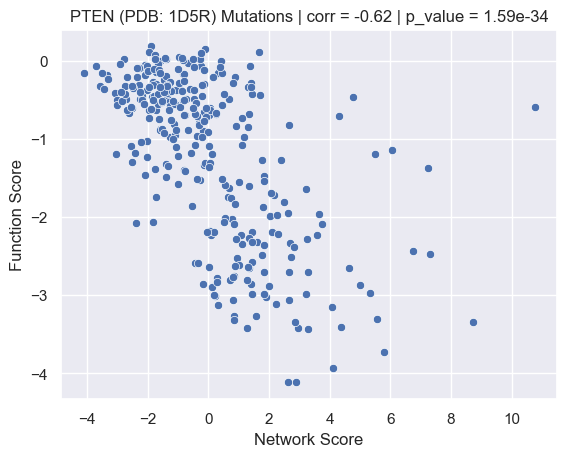

In [45]:
final_sum = read_finalsum("1D5R", "A")

# merge pten_data with final_sum
merged = pten_data.merge(final_sum, left_on='residue_number', right_on='num')
merged.head()

corr, p_value = spearmanr(merged['network_score'], merged['Cum_score_avg'])

# plot scatterplot for each metric (y) vs score (x) as subplot
sns.scatterplot(data=merged, x='network_score', y='Cum_score_avg')
plt.xlabel("Network Score")
plt.ylabel("Function Score")
plt.title(f"PTEN (PDB: 1D5R) Mutations | corr = {corr:.2f} | p_value = {p_value:.2e}")


# BRCA1

In [46]:
brca1_data = pd.read_excel("BRCA1_mut_func_scores.xlsx")
brca1_data.head()

,exp.,chr.,pos.hg19,ref,alt,transcript.variant,protein.variant,conseq.,function.score,functional.class,RNA.score,protein.variant.HGVS
0,exon2,17,41276135,T,G,c.-19-3A>C,NaN,Splice region,-0.372611,FUNC,NaN,NaN
1,exon2,17,41276135,T,C,c.-19-3A>G,NaN,Splice region,-0.045313,FUNC,NaN,NaN
2,exon2,17,41276135,T,A,c.-19-3A>T,NaN,Splice region,-0.108254,FUNC,NaN,NaN
3,exon2,17,41276134,T,G,c.-19-2A>C,NaN,Canonical splice,-0.277963,FUNC,NaN,NaN
4,exon2,17,41276134,T,C,c.-19-2A>G,NaN,Canonical splice,-0.388414,FUNC,NaN,NaN


In [47]:
brca1_data['conseq.'].value_counts()

conseq.
Missense            2086
Synonymous           544
Intronic             489
Splice region        446
Canonical splice     143
Nonsense             138
5' UTR                47
Name: count, dtype: int64

In [48]:
tmp = brca1_data[(~brca1_data['protein.variant.HGVS'].isna()) & (brca1_data['conseq.'] != "Nonsense")].reset_index(drop=True)
tmp.head()

,exp.,chr.,pos.hg19,ref,alt,transcript.variant,protein.variant,conseq.,function.score,functional.class,RNA.score,protein.variant.HGVS
0,exon2,17,41276113,T,C,c.1A>G,p.M1V,Missense,-2.025645,LOF,-0.479654,p.Met1Val
1,exon2,17,41276113,T,A,c.1A>T,p.M1L,Missense,-1.965629,LOF,-0.464785,p.Met1Leu
2,exon2,17,41276113,T,G,c.1A>C,p.M1L,Missense,-2.516529,LOF,-0.513608,p.Met1Leu
3,exon2,17,41276112,A,G,c.2T>C,p.M1T,Missense,-1.656569,LOF,-0.329138,p.Met1Thr
4,exon2,17,41276112,A,C,c.2T>G,p.M1R,Missense,-2.481580,LOF,-0.642796,p.Met1Arg


In [49]:
tmp['residue_number'] = tmp['protein.variant.HGVS'].str.extract(r'(\d+)').astype(int)
tmp['aa'] = tmp['protein.variant.HGVS'].apply(lambda x: seq1(x.split('.')[1][:3]))

# groupby residue number and calculate mean of each function.score
tmp = tmp.groupby(['residue_number', 'aa'])['function.score'].mean().reset_index()
tmp

,residue_number,aa,function.score
0,1,M,-2.100910
1,2,D,-0.531415
2,3,L,-0.121159
3,4,S,-0.167550
4,5,A,-0.202464
...,...,...,...
321,1851,D,-0.359463
322,1852,T,-0.132445
323,1853,Y,-1.745664
324,1854,L,-0.238388


In [50]:
tmp['function.score']
# range of function.score
tmp['function.score'].min(), tmp['function.score'].max()

# residue number at which function.score is min
tmp[tmp['function.score'] == tmp['function.score'].min()]

,residue_number,aa,function.score
95,96,D,-2.916086


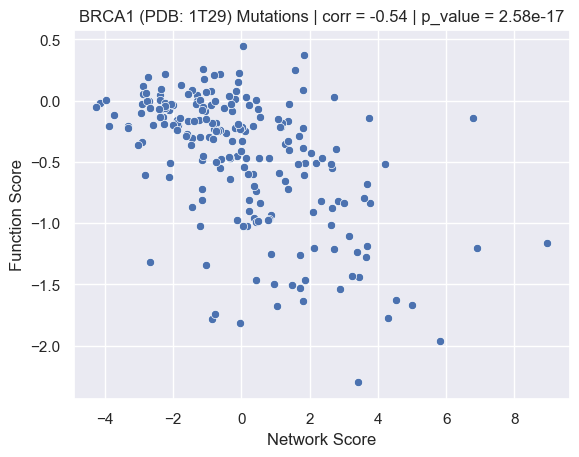

In [52]:
# need to match residue number with correct gene, because there are multiple genes in the same pdb
"""DBREF  1T29 A 1646  1859  UNP    P38398   BRCA1_HUMAN   1646   1859             
DBREF  1T29 B    1    14  UNP    Q9BX63   BRIP1_HUMAN    985    998        """
final_sum = read_finalsum("1T29", "A")

# merge pten_data with final_sum
merged = tmp.merge(final_sum, left_on='residue_number', right_on='num')
merged = merged[merged['num'].isin(list(range(1646,1859+1)))]
merged

# calculate spearman correlation between network score and function score
corr, p_value = spearmanr(merged['network_score'], merged['function.score'])

# plot scatterplot for each metric (y) vs score (x) as subplot
sns.scatterplot(data=merged, x='network_score', y='function.score')
plt.xlabel("Network Score")
plt.ylabel("Function Score")
plt.title(f"BRCA1 (PDB: 1T29) Mutations | corr = {corr:.2f} | p_value = {p_value:.2e}")
plt.show()